In [1]:
import requests
import pandas as pd
import numpy as np
import os
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from process_daily_data import save_df, get_dataframe, BASE_URL, STOCK, my_list, russell_ticker_set

In [4]:
cmgs = [item for item in os.listdir('data/daily_data/') if 'cmg' in item.split('_')]
cmgs.sort()

In [5]:
first_df = pd.read_csv('data/daily_data/{}'.format(cmgs[0]))
for cmg in cmgs[1:]:
    this_df = pd.read_csv('data/daily_data/{}'.format(cmg))
    first_df = pd.concat([first_df, this_df])

In [9]:
# cols = first_df.columns.tolist()
# cols_to_drop = cols[:4] + ['label', 'changeOverTime', 'close', 'high', 'low', 'marketAverage',
#                            'marketClose', 'marketOpen', 'volume', 'numberOfTrades', 
#                            'notional', 'open', 'marketChangeOverTime']

In [8]:
# first_df.drop(cols_to_drop, axis=1, inplace=True)
# # necessary
# first_df.reset_index(drop=True, inplace=True)

In [9]:
# idx_to_drop = first_df.index[first_df.marketNotional == 0.0]
# first_df.drop(idx_to_drop, inplace=True)
# first_df.reset_index(drop=True, inplace=True)
# first_df.describe()

In [10]:
# first_df.date = first_df.date.map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
# first_df['weekday'] = first_df.date.map(lambda x: str(x.weekday()))
# first_df['month'] = first_df.date.map(lambda x: str(x.month))

In [11]:
# first_df.minute = first_df.minute.map(lambda x: datetime.datetime.strptime(x, '%H:%M'))
# first_df['hour'] = first_df.minute.map(lambda x: str(x.hour))

In [6]:
import datetime
def get_processed_minute_data(df):
    cols = df.columns.tolist()
    cols_to_drop = cols[:4] + ['label', 'changeOverTime', 'close', 'high', 
                               'low', 'marketAverage', 'marketClose', 
                               'marketOpen', 'volume', 'numberOfTrades', 
                               'notional', 'open', 'marketChangeOverTime']
    df.drop(cols_to_drop, axis=1, inplace=True)
    # necessary
    df.reset_index(drop=True, inplace=True)
    
    idx_to_drop = df.index[df.marketNotional == 0.0]
    df.drop(idx_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df.date = df.date.map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df['weekday'] = df.date.map(lambda x: str(x.weekday()))
    df['month']   = df.date.map(lambda x: str(x.month))
    
    df.minute = first_df.minute.map(lambda x: datetime.datetime.strptime(x, '%H:%M'))
    df['hour'] = first_df.minute.map(lambda x: str(x.hour))
    
    return df

first_df = get_processed_minute_data(first_df)

In [7]:
def get_numeric_categoric(df):
    numeric_cols, categorical_cols = [], []

    for col in first_df:
        if np.issubdtype(df[col].dtype, np.number):
            numeric_cols += [col]
        else:
            categorical_cols += [col]
    
    return numeric_cols, categorical_cols

In [8]:
numericl_cols, categorical_cols = get_numeric_categoric(first_df)
numericl_cols, categorical_cols

(['marketHigh',
  'marketLow',
  'marketNotional',
  'marketNumberOfTrades',
  'marketVolume'],
 ['date', 'minute', 'weekday', 'month', 'hour'])

In [9]:
def delta_dataframe(df, numeric_columns):
    '''
    log numerical columns, then return deltas
    '''
    
    added_columns = []
    for shift in [3, 5, 10, 20]:
        for col in numeric_columns:
            new_col_name = col + '_' + str(shift)
            df[new_col_name] = df[col].shift(shift)
            added_columns += [new_col_name]

    df[numeric_columns+added_columns] = df[numeric_columns+added_columns].apply(np.log)
    
    # for lookbacks
    for new_col in added_columns:
        original_col = new_col.split('_')[0]
        df[new_col] = df[original_col] - df[new_col]
    
    # for today
    # This line is necessary
    temp = df[numeric_columns] - df[numeric_columns].shift(1)
    df[numeric_columns] = temp
    
    assert (df.index == np.arange(len(first_df))).all()
    df.drop(df.index[list(range(20))], axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [10]:
first_df = delta_dataframe(first_df, numericl_cols)
first_df.describe()

,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketVolume,marketHigh_3,marketLow_3,marketNotional_3,marketNumberOfTrades_3,marketVolume_3,...,marketHigh_10,marketLow_10,marketNotional_10,marketNumberOfTrades_10,marketVolume_10,marketHigh_20,marketLow_20,marketNotional_20,marketNumberOfTrades_20,marketVolume_20
count,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,...,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000,9636.000000
mean,0.000010,0.000009,0.000546,0.000509,0.000536,0.000029,0.000029,0.001056,0.000944,0.001027,...,0.000095,0.000096,0.002527,0.002288,0.002431,0.000192,0.000196,0.004639,0.003990,0.004445
std,0.001060,0.001136,1.875454,1.314247,1.875470,0.001815,0.001860,1.870390,1.299166,1.870408,...,0.003303,0.003336,1.917313,1.340305,1.917343,0.004753,0.004798,1.977734,1.375164,1.977768
min,-0.009287,-0.016011,-9.737805,-5.780744,-9.737905,-0.014290,-0.018523,-8.453899,-5.641907,-8.454253,...,-0.020738,-0.021170,-8.408788,-4.974432,-8.419801,-0.027329,-0.028410,-9.142410,-5.068904,-9.132487
25%,-0.000461,-0.000424,-1.028174,-0.840009,-1.028319,-0.000893,-0.000854,-0.993720,-0.810930,-0.993972,...,-0.001731,-0.001652,-1.040293,-0.847298,-1.040839,-0.002442,-0.002373,-1.086983,-0.875469,-1.087573
50%,-0.000006,0.000021,-0.019464,0.000000,-0.019489,-0.000015,0.000042,0.007532,0.000000,0.006793,...,-0.000043,0.000011,0.021727,0.000000,0.021350,0.000069,0.000149,0.033382,0.000000,0.036022
75%,0.000435,0.000475,0.990990,0.810930,0.991232,0.000850,0.000885,1.005874,0.810930,1.006254,...,0.001680,0.001756,1.063547,0.869038,1.062480,0.002584,0.002703,1.116235,0.916291,1.115391
max,0.020955,0.021290,8.791507,4.532599,8.787983,0.024005,0.017813,8.805578,4.488636,8.806124,...,0.023029,0.021556,8.543134,4.795791,8.546364,0.031003,0.032480,8.377414,4.905275,8.367532


In [11]:
numericl_cols, _ = get_numeric_categoric(first_df)

In [12]:
label = first_df[['marketHigh', 'marketLow']]    
label_10, label_5 = label.shift(-10), label.shift(-5)

idx_to_del = np.arange(len(label_10)-10, len(label_10))
label_10.drop(idx_to_del, inplace=True)
label_5.drop(idx_to_del, inplace=True)
first_df.drop(idx_to_del, inplace=True)


In [13]:
import tensorflow as tf
import tensorflow.contrib.timeseries as ts
import multiprocessing
import pandas as pd
import numpy as np
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

In [14]:
first_df.head()

,date,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketVolume,minute,weekday,month,hour,...,marketHigh_10,marketLow_10,marketNotional_10,marketNumberOfTrades_10,marketVolume_10,marketHigh_20,marketLow_20,marketNotional_20,marketNumberOfTrades_20,marketVolume_20
0,2018-10-08,0.000335,-0.001343,2.488976,2.251292,2.488793,1900-01-01 09:50:00,0,10,9,...,0.000290,0.002249,-0.572715,-0.862224,-0.574248,-0.001338,-0.001030,-1.024977,1.152680,-1.023449
1,2018-10-08,0.001249,0.000740,-1.376530,-0.864997,-1.377797,1900-01-01 09:51:00,0,10,9,...,0.002679,0.002467,-1.740011,-1.252763,-1.743431,0.001204,0.006091,-2.633553,-2.079442,-2.636637
2,2018-10-08,-0.000071,0.002004,0.024437,-0.693147,0.024317,1900-01-01 09:52:00,0,10,9,...,0.001781,0.003334,-0.630116,-1.011601,-0.632804,0.006257,0.007583,2.349906,-0.223144,2.342407
3,2018-10-08,0.002209,-0.000274,0.586726,1.504077,0.585448,1900-01-01 09:53:00,0,10,9,...,0.002994,0.003071,1.013747,1.280934,1.009096,0.008287,0.007300,0.377810,1.504077,0.370143
4,2018-10-08,0.004399,0.003062,0.623435,-0.117783,0.619425,1900-01-01 09:54:00,0,10,9,...,0.005066,0.004122,1.334428,0.470004,1.329436,0.008768,0.009742,-0.789685,-1.417066,-0.798958


In [15]:
first_df.date = np.arange(len(first_df))

In [16]:
HEADER = first_df.columns.tolist()
TIME_INDEX_FEATURE_NAME = 'date'
VALUE_FEATURE_NAMES = numericl_cols

In [17]:
def generate_input_fn(dataframe, mode, header_lines=1, batch_size=None, 
                      windows_size=None, tail_count=None):
    
    if tail_count is not None:
        dataframe = dataframe.tail(tail_count)
    
    print("Dataset Size: {}".format(len(dataframe)))
    print("")
    
    
    data = {
        ts.TrainEvalFeatures.TIMES: dataframe[TIME_INDEX_FEATURE_NAME],
        ts.TrainEvalFeatures.VALUES: dataframe[VALUE_FEATURE_NAMES],
    }
    
    reader = ts.NumpyReader(data)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        input_fn = tf.contrib.timeseries.RandomWindowInputFn(
            reader, 
            batch_size=batch_size, 
            window_size=windows_size,
        )
        
    elif mode == tf.estimator.ModeKeys.EVAL:
        input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    
    return input_fn

In [18]:
def create_estimator(run_config, hparams):

    estimator = ts.ARRegressor(
        periodicities= hparams.periodicities, 
        input_window_size= hparams.input_window_size, 
        output_window_size= hparams.output_window_size,
        num_features=len(VALUE_FEATURE_NAMES),
        loss=hparams.loss,
        hidden_layer_sizes = hparams.hidden_units,
        optimizer = tf.train.AdagradOptimizer(learning_rate=hparams.learning_rate),
        config=run_config
    )
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

In [19]:
hparams  = tf.contrib.training.HParams(
    training_steps = 10000,
    periodicities = [10],
    input_window_size = 32,
    output_window_size=5,
    batch_size = 16,
    loss = tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = [32,32,16],
    learning_rate = 1e-5,
)

In [20]:
CHECKPOINT_STEPS=1000
MODEL_NAME = 'ts-model-01'


model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig().replace(
    save_checkpoints_steps=CHECKPOINT_STEPS,
    tf_random_seed=19830610,
    model_dir=model_dir,
)
                                             
print("Model directory: {}".format(run_config.model_dir))
print("Hyper-parameters: {}".format(hparams))
print("")

train_input_fn = generate_input_fn(
    dataframe=first_df,
    mode = tf.estimator.ModeKeys.TRAIN,
    batch_size=hparams.batch_size,
    windows_size = hparams.input_window_size + hparams.output_window_size
)

Model directory: trained_models/ts-model-01
Hyper-parameters: [('batch_size', 16), ('hidden_units', [32, 32, 16]), ('input_window_size', 32), ('learning_rate', 1e-05), ('loss', 'normal_likelihood_loss'), ('output_window_size', 5), ('periodicities', [10]), ('training_steps', 10000)]

Dataset Size: 9626



In [21]:
estimator = create_estimator(run_config, hparams)

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/ts-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdb6dad6a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>



In [22]:
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Estimator training started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................")

estimator.train(input_fn=train_input_fn, steps=hparams.training_steps)

time_end = datetime.utcnow() 
print(".......................................")
print("Estimator training finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Estimator training elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Estimator training started at 04:17:20
.......................................
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_models/ts-model-01/model.ckpt-90100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 90100 into trained_models/ts-model-01/model.ckpt.
INFO:tensorflow:loss = 0.9944474, step = 90100
INFO:tensorflow:global_step/sec: 161.356
INFO:tensorflow:loss = 1.1682923, step = 90200 (0.622 sec)
INFO:tensorflow:global_step/sec: 169.63
INFO:tensorflow:loss = 1.1602355, step = 90300 (0.588 sec)
INFO:tensorflow:global_step/sec: 159.043
INFO:tensorflow:loss = 1.1630162, step = 90400 (0.629 sec)
INFO:tensorflow:global_step/sec: 183.787
INFO:tensorflow:loss = 1.1675628, step = 90500 (0.545 sec)
INFO:tensorflow:global_step/sec: 189.504
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 248.339
INFO:tensorflow:loss = 1.2360803, step = 97300 (0.403 sec)
INFO:tensorflow:global_step/sec: 253.318
INFO:tensorflow:loss = 1.0055124, step = 97400 (0.395 sec)
INFO:tensorflow:global_step/sec: 247.829
INFO:tensorflow:loss = 1.0652417, step = 97500 (0.404 sec)
INFO:tensorflow:global_step/sec: 257.364
INFO:tensorflow:loss = 1.1277812, step = 97600 (0.390 sec)
INFO:tensorflow:global_step/sec: 219.357
INFO:tensorflow:loss = 1.0726447, step = 97700 (0.454 sec)
INFO:tensorflow:global_step/sec: 252.137
INFO:tensorflow:loss = 1.0996354, step = 97800 (0.397 sec)
INFO:tensorflow:global_step/sec: 260.142
INFO:tensorflow:loss = 1.0382352, step = 97900 (0.384 sec)
INFO:tensorflow:global_step/sec: 247.864
INFO:tensorflow:loss = 1.1525136, step = 98000 (0.404 sec)
INFO:tensorflow:Saving checkpoints for 98100 into trained_models/ts-model-01/model.ckpt.
INFO:tensorflow:global_step/sec: 212.836
INFO:tensorflow:loss = 1.1352805, step = 98100 (0.471 sec)
INFO:tensor

In [23]:
hparams  = tf.contrib.training.HParams(
    training_steps = 10000,
    periodicities = [10],
    input_window_size = 32,
    output_window_size= 5,
    batch_size = 16,
    loss = tf.contrib.timeseries.ARModel.SQUARED_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = [32,32,16],
    learning_rate = 0.001
    
)

estimator = create_estimator(run_config, hparams)

eval_input_fn = generate_input_fn(
    first_df,
    mode = tf.estimator.ModeKeys.EVAL,
)

tf.logging.set_verbosity(tf.logging.WARN)
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)
print("")
print(evaluation.keys())
print("")
print("Evaluation Loss ({}) : {}".format(hparams.loss, evaluation['loss']))

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/ts-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdb6dad6a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>

Dataset Size: 9626


dict_keys(['covariance', 'loss', 'mean', 'observed', 'start_tuple', 'times', 'global_step'])

Evaluation Loss (squared_loss) : 1.590480923652649


In [24]:
def compute_rmse(a, b):
    rmse =  np.sqrt(np.sum(np.square(a - b)) / len(a))
    return round(rmse,5)

def compute_mae(a, b):
    mae =  np.sqrt(np.sum(np.abs(a - b)) / len(a))
    return round(mae,5)

x_current = evaluation['times'][0]
y_current_actual = evaluation['observed'][0].reshape(-1)
y_current_estimated = evaluation['mean'][0].reshape(-1)

rmse = compute_rmse(y_current_actual, y_current_estimated)
mae = compute_mae(y_current_actual, y_current_estimated)
print("Evaluation RMSE {}".format(rmse))
print("Evaluation MAE {}".format(mae))

Evaluation RMSE 1.26114
Evaluation MAE 0.84895


### NOT that good a fit

In [25]:
x_current = np.arange(len(y_current_actual))

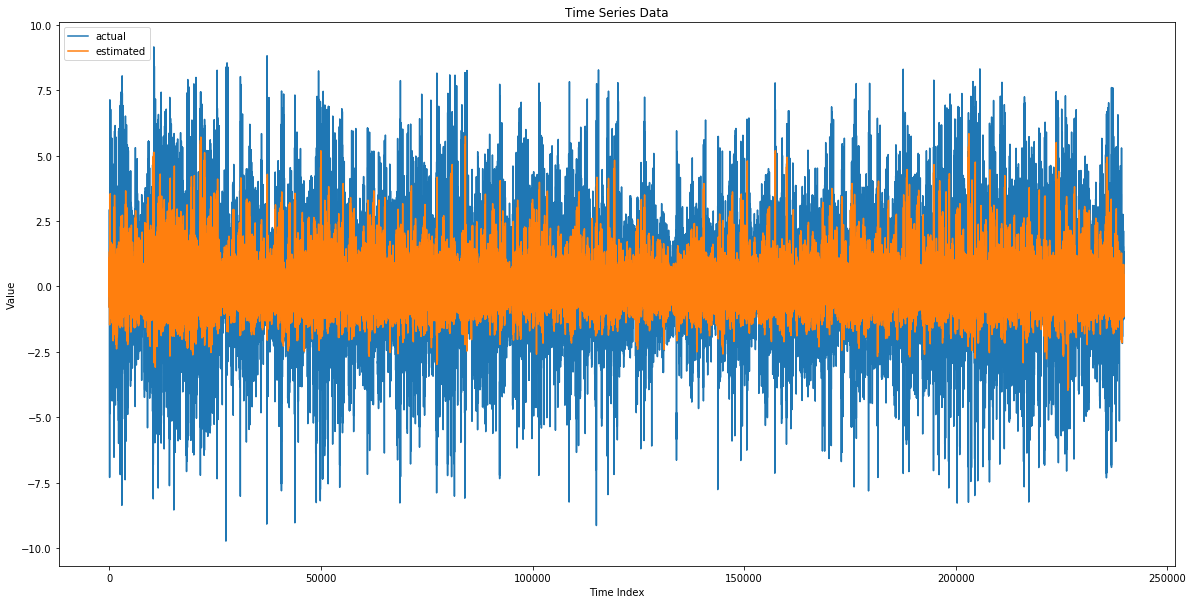

In [26]:
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_current, y_current_actual, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()